In [1]:
import torch
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
import numpy as np

from sparc.post_analysis import HDF5AnalysisResultsDataset 
from sparc.feature_extract.extract_open_images import OpenImagesDataset

In [2]:
dataset=  OpenImagesDataset(dataset_dir='/home/ubuntu/Projects/OpenImages/', split='test')

Loading caption data from /home/ubuntu/Projects/OpenImages/captions/test/simplified_open_images_test_localized_narratives.json...
Loading label data...
Total number of classes: 601
Loading annotations from /home/ubuntu/Projects/OpenImages/labels/test-annotations-human-imagelabels-boxable.csv...
Loaded labels for 112194 images


In [3]:
batch_size_used_for_generation = 256
analysis_results_local = HDF5AnalysisResultsDataset('../../final_results/msae_open_local_with_cross/analysis_cache_val.h5', 
                                                    batch_size_used_for_generation)
analysis_results_no_cross = HDF5AnalysisResultsDataset('../../final_results/msae_open_local_no_cross/analysis_cache_val.h5',
                                                      batch_size_used_for_generation)

# should get retrieval version where global top-k is disabled
analysis_results_global = HDF5AnalysisResultsDataset('../../final_results/msae_open_global_with_cross/analysis_cache_retrieval_val.h5',
                                                     batch_size_used_for_generation)

In [4]:
feature_type = 'latents'
text_latents_global = csr_matrix(analysis_results_global.get_all_features_for_stream('clip_txt', feature_type))
text_latents_local = csr_matrix(analysis_results_local.get_all_features_for_stream('clip_txt', feature_type))
text_latents_no_cross = csr_matrix(analysis_results_no_cross.get_all_features_for_stream('clip_txt', feature_type))

text_latents_global = normalize(text_latents_global)
text_latents_local = normalize(text_latents_local)
text_latents_no_cross = normalize(text_latents_no_cross)

# Image -> Caption 

In [5]:
def plot_img_final(img_index, loc, text_latents_global, text_latents_local, text_latents_no_cross, top_k=5):
    import matplotlib.pyplot as plt
    
    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(dataset[img_index]['image'])
    plt.axis('off')
    plt.title(f"Image #{img_index}", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    models_config = [
        ('global', analysis_results_global, text_latents_global),
        ('local', analysis_results_local, text_latents_local), 
        ('no_cross', analysis_results_no_cross, text_latents_no_cross)
    ]
    
    feature_types = ['dino', 'clip_img']
    results = {}
    
    for feature_type in feature_types:
        results[feature_type] = {}
        
        for model_name, analysis_results, text_latents in models_config:
            img_latent = analysis_results[img_index][feature_type][loc]
            if isinstance(img_latent, torch.Tensor):
                img_latent = img_latent.cpu().numpy()
            
            img_latent_col = img_latent.reshape(-1, 1)
            similarities = text_latents @ img_latent_col
            similarities_array = similarities.flatten()
            
            if top_k >= len(similarities_array):
                top_indices = np.argsort(similarities_array)[::-1][:top_k]
            else:
                top_indices_unsorted = np.argpartition(similarities_array, -top_k)[-top_k:]
                top_indices = top_indices_unsorted[np.argsort(similarities_array[top_indices_unsorted])][::-1]
            
            top_results = [(dataset[idx]['captions'], similarities_array[idx], idx) for idx in top_indices]
            results[feature_type][model_name] = top_results
    
    return results

In [6]:
from IPython.display import display, HTML

def display_results_html(results, img_index, captions_dict=None):
    html = f"""
    <div style="font-family: monospace; background: #f8f9fa; padding: 20px; border-radius: 5px;">
        <h2 style="border-bottom: 3px solid #333; padding-bottom: 10px;">
            📸 Top Similar Results for Image #{img_index}
        </h2>
    """
    
    for feature_type in ['dino', 'clip_img']:
        html += f"""
        <div style="margin: 30px 0;">
            <h3 style="background: #e9ecef; padding: 10px; margin: 0; color: #495057;">
                🔍 {feature_type.upper()} Features
            </h3>
        """
        
        for model_name in ['global', 'local', 'no_cross']:
            html += f"""
            <div style="margin: 20px 0; border-left: 4px solid #6c757d; padding-left: 15px;">
                <h4 style="color: #6c757d; margin: 10px 0;">
                    ⚙️ {model_name.title()} Model
                </h4>
            """
            
            for rank, (caption, sim, idx) in enumerate(results[feature_type][model_name], 1):                
                # Highlight if this is the target image
                bg_color = "#d4edda" if idx == img_index else "#ffffff"
                border_color = "#28a745" if idx == img_index else "#dee2e6"
                
                html += f"""
                <div style="background: {bg_color}; border: 1px solid {border_color}; 
                           margin: 10px 0; padding: 10px; border-radius: 3px;">
                    <div style="font-weight: bold; color: #495057;">
                        {rank}. Similarity: {sim:.4f}
                    </div>
                    <div style="margin-top: 5px; color: #6c757d;">
                        Caption: {caption}
                    </div>
                </div>
                """
            
            html += "</div>"
        html += "</div>"
    
    html += "</div>"
    display(HTML(html))

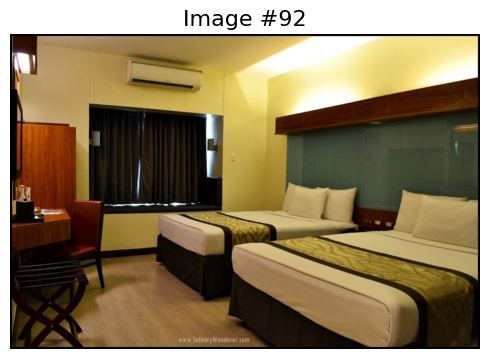

In [7]:
img_index = 92
feature_type = 'latents'
results = plot_img_final(img_index, feature_type, text_latents_global, 
                         text_latents_local ,text_latents_no_cross,  top_k=5)

In [8]:
display_results_html(results, img_index)

# Caption -> Image

In [9]:
feature_type = 'latents'
dino_img_latents_global = csr_matrix(analysis_results_global.get_all_features_for_stream('dino', feature_type))
dino_img_latents_local = csr_matrix(analysis_results_local.get_all_features_for_stream('dino', feature_type))
dino_img_latents_no_cross = csr_matrix(analysis_results_no_cross.get_all_features_for_stream('dino', feature_type))


clip_img_latents_global = csr_matrix(analysis_results_global.get_all_features_for_stream('clip_img', feature_type))
clip_img_latents_local = csr_matrix(analysis_results_local.get_all_features_for_stream('clip_img', feature_type))
clip_img_latents_no_cross = csr_matrix(analysis_results_no_cross.get_all_features_for_stream('clip_img', feature_type))


dino_img_latents_global = normalize(dino_img_latents_global)
dino_img_latents_local = normalize(dino_img_latents_local)
dino_img_latents_no_cross = normalize(dino_img_latents_no_cross)

clip_img_latents_global = normalize(clip_img_latents_global)
clip_img_latents_local = normalize(clip_img_latents_local)
clip_img_latents_no_cross = normalize(clip_img_latents_no_cross)

In [10]:
def get_similar_images_for_caption(caption_index, top_k=9):
    import numpy as np
    
    latents_mapping = {
        ('dino', 'global'): dino_img_latents_global,
        ('dino', 'local'): dino_img_latents_local,
        ('dino', 'no_cross'): dino_img_latents_no_cross,
        ('clip_img', 'global'): clip_img_latents_global,
        ('clip_img', 'local'): clip_img_latents_local,
        ('clip_img', 'no_cross'): clip_img_latents_no_cross,
    }
    
    text_latents_mapping = {
        'global': text_latents_global,
        'local': text_latents_local,
        'no_cross': text_latents_no_cross,
    }
    
    stream_types = ['dino', 'clip_img']
    model_types = ['global', 'local', 'no_cross']
    
    results = {}
    
    for stream_type in stream_types:
        results[stream_type] = {}
        
        for model_type in model_types:
            text_latents = text_latents_mapping[model_type]
            text_latent = text_latents[caption_index].toarray().flatten()
            
            img_latents = latents_mapping[(stream_type, model_type)]
            
            text_latent_col = text_latent.reshape(-1, 1)
            similarities = img_latents @ text_latent_col
            similarities_array = similarities.flatten()
            
            top_indices = np.argsort(similarities_array)[-top_k:][::-1]
            top_similarities = [(idx, similarities_array[idx]) for idx in top_indices]
            
            results[stream_type][model_type] = top_similarities
    
    return results

In [11]:
def plot_caption_results(caption_index, results, target_size=(512, 512), plot_title=True,
                         border_width=10, padding=5, use_center_crop=True):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.patches import Rectangle
    
    models_config = [
        {"name": "Global TopK (DINO)", "model": "global", "stream": "dino"},
        {"name": "Local TopK (DINO)", "model": "local", "stream": "dino"},
        {"name": "Global TopK (CLIP)", "model": "global", "stream": "clip_img"},
        {"name": "Local TopK (CLIP)", "model": "local", "stream": "clip_img"}
    ]
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    
    def resize_and_border(img, add_border=False, rank=None):
        if not isinstance(img, np.ndarray):
            img = np.array(img)
        
        if len(img.shape) == 2:
            img = np.stack([img, img, img], axis=2)
        
        from scipy.ndimage import zoom
        h, w = img.shape[:2]
        
        if use_center_crop:
            # Center crop to preserve aspect ratio
            target_h, target_w = target_size
            original_aspect = w / h
            target_aspect = target_w / target_h
            
            if original_aspect > target_aspect:
                # Image is too wide, crop width
                new_w = int(h * target_aspect)
                start_w = (w - new_w) // 2
                img = img[:, start_w:start_w + new_w]
            elif original_aspect < target_aspect:
                # Image is too tall, crop height
                new_h = int(w / target_aspect)
                start_h = (h - new_h) // 2
                img = img[start_h:start_h + new_h, :]
            
            h, w = img.shape[:2]
        
        zoom_h, zoom_w = target_size[0]/h, target_size[1]/w
        resized_img = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
        for c in range(3):
            resized_img[:, :, c] = zoom(img[:, :, c], (zoom_h, zoom_w), order=1)
        
        # Add rank number using simple overlay - make size relative to image
        if rank is not None:
            # Calculate circle size as percentage of image size
            base_size = min(target_size[0], target_size[1])
            radius = max(12, int(base_size * 0.06))  # 6% of smaller dimension, min 12px
            margin = max(5, int(base_size * 0.02))   # 2% margin from edge, min 5px
            
            y_center = margin + radius
            x_center = margin + radius
            
            y, x = np.ogrid[:target_size[0], :target_size[1]]
            mask = (x - x_center)**2 + (y - y_center)**2 <= radius**2
            resized_img[mask] = [255, 255, 255]  # White circle
            
            # Add black border to circle
            border_width = max(1, radius // 12)  # Border width scales with radius
            border_mask = ((x - x_center)**2 + (y - y_center)**2 <= (radius + border_width)**2) & \
                         ((x - x_center)**2 + (y - y_center)**2 > radius**2)
            resized_img[border_mask] = [0, 0, 0]  # Black border
        
        return resized_img, rank
    
    def create_3x3_grid(img_indices, caption_idx, pad):
        grid_images = []
        rank_positions = []
        correct_positions = []
        
        for i, idx in enumerate(img_indices):
            img = dataset[idx]['image']
            resized_img, rank = resize_and_border(img, add_border=False, rank=i+1)
            grid_images.append(resized_img)
            rank_positions.append(rank)
            if idx == caption_idx:
                correct_positions.append(i)
        
        if pad == 0:
            rows = []
            for i in range(3):
                row = np.hstack((grid_images[i*3], grid_images[i*3+1], grid_images[i*3+2]))
                rows.append(row)
            grid = np.vstack(rows)
            return grid, rank_positions, correct_positions
        
        single_height, single_width = target_size
        grid_height = 3 * single_height + 2 * pad
        grid_width = 3 * single_width + 2 * pad
        
        grid = np.ones((grid_height, grid_width, 3), dtype=np.uint8) * 255
        
        for i in range(3):
            for j in range(3):
                idx = i * 3 + j
                start_h = i * (single_height + pad)
                end_h = start_h + single_height
                start_w = j * (single_width + pad)
                end_w = start_w + single_width
                grid[start_h:end_h, start_w:end_w] = grid_images[idx]
        
        return grid, rank_positions, correct_positions
    
    for col_idx, config in enumerate(models_config):
        top_similarities = results[config["stream"]][config["model"]]
        indices = [idx for idx, _ in top_similarities]
        
        ax = axes[col_idx]
        if plot_title:
            ax.set_title(config["name"], fontsize=16, fontweight='normal')
        
        grid, ranks, correct_positions = create_3x3_grid(indices, caption_index, padding)
        ax.imshow(grid)
        
        # Add green rectangles for correct images
        for pos in correct_positions:
            row = pos // 3
            col = pos % 3
            if padding == 0:
                x = col * target_size[1]
                y = row * target_size[0]
                width = target_size[1]
                height = target_size[0]
            else:
                x = col * (target_size[1] + padding)
                y = row * (target_size[0] + padding)
                width = target_size[1]
                height = target_size[0]
            
            rect = Rectangle((x, y), width-1, height-1, 
                           linewidth=4, edgecolor='green', facecolor='none')
            ax.add_patch(rect)
        
        # Calculate text positions and font size relative to image size
        base_size = min(target_size[0], target_size[1])
        font_size = max(6, int(base_size * 0.01))  # 4% of smaller dimension, min 6pt
        margin = max(5, int(base_size * 0.02))
        radius = max(12, int(base_size * 0.06))
        text_offset = margin + radius
        
        if padding == 0:
            positions = []
            for i in range(3):
                for j in range(3):
                    x = j * target_size[1] + text_offset
                    y = i * target_size[0] + text_offset
                    positions.append((x, y))
        else:
            positions = []
            for i in range(3):
                for j in range(3):
                    x = j * (target_size[1] + padding) + text_offset
                    y = i * (target_size[0] + padding) + text_offset
                    positions.append((x, y))
        
        for i, (x, y) in enumerate(positions):
            ax.text(x, y, str(i+1), fontsize=font_size, fontweight='bold', color='black', 
                   ha='center', va='center')
        
        ax.axis('off')
    
    plt.tight_layout(pad=0.5)
    return fig

In this image in the center there is one bird flying, and in the background there is sky.


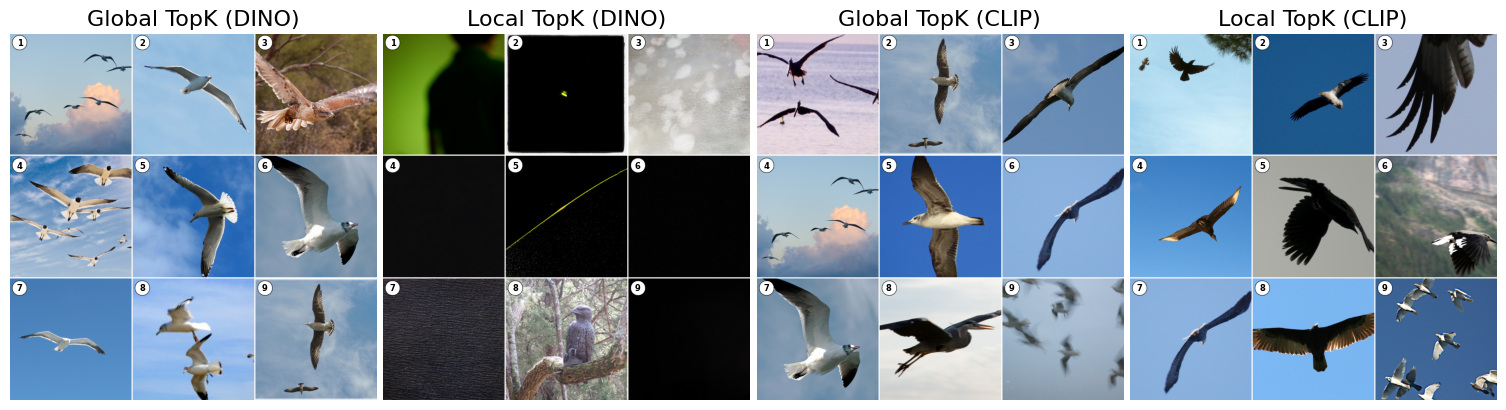

In [12]:
caption_index = 4111

print(dataset[caption_index]['captions'])
results = get_similar_images_for_caption(caption_index, 9)

fig = plot_caption_results(caption_index, results, target_size=(512, 512), plot_title=True, use_center_crop=True)

# Image -> Image

In [13]:
def plot_similar_images(img_index, feature_type, k=5, show_title=True, show_plot=False):
    """
    Cross-modal image retrieval with 4×k layout: DINO (Global/Local) + CLIP (Global/Local)
    Returns PIL Image instead of showing plot
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    import io
    from matplotlib.patches import Rectangle
    
    def resize_image(img, size=(224, 224)):
        if isinstance(img, Image.Image):
            return img.resize(size, Image.Resampling.LANCZOS)
        else:
            img_pil = Image.fromarray(img)
            return img_pil.resize(size, Image.Resampling.LANCZOS)
    
    def get_top_k_similar(query_vector, target_matrix, k):
        similarities = target_matrix @ query_vector.T
        similarities = similarities.flatten()
        top_indices = np.argsort(similarities)[::-1][:k]
        return top_indices
    
    # Create the 4×k retrieved images plot
    fig_retrieved, axes = plt.subplots(4, k+1, figsize=(k*2+1, 8), 
                                      gridspec_kw={
                                          'width_ratios': [1]*k + [0.3],
                                          'hspace': 0.02,
                                          'wspace': 0.05
                                      })
    configurations = [
        ('DINO Global', analysis_results_global[img_index]['dino'][feature_type], clip_img_latents_global),
        ('DINO Local', analysis_results_local[img_index]['dino'][feature_type], clip_img_latents_local),
        ('CLIP Global', analysis_results_global[img_index]['clip_img'][feature_type], dino_img_latents_global),
        ('CLIP Local', analysis_results_local[img_index]['clip_img'][feature_type], dino_img_latents_local)
    ]
    
    for row, (model_name, query_vector, target_matrix) in enumerate(configurations):
        top_k_indices = get_top_k_similar(query_vector, target_matrix, k)
        
        for col, idx in enumerate(top_k_indices):
            img_resized = resize_image(dataset[idx]['image'])
            axes[row, col].imshow(img_resized)
            axes[row, col].axis('off')
            
            # Add blue border for matching images
            if idx == img_index:
                rect = Rectangle((0, 0), img_resized.width-1, img_resized.height-1, 
                               linewidth=12, edgecolor='green', facecolor='none')
                axes[row, col].add_patch(rect)
        
        # Add model name
        axes[row, -1].text(0.5, 0.5, model_name, transform=axes[row, -1].transAxes, 
                          rotation=90, va='center', ha='center', fontsize=16, fontweight='normal')
        axes[row, -1].axis('off')
    
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0.02, wspace=0.05)
    
    # Render 4×k plot to memory
    buf = io.BytesIO()
    fig_retrieved.savefig(buf, format='png', bbox_inches='tight', dpi=100, pad_inches=0)
    buf.seek(0)
    retrieved_img = Image.open(buf).copy()
    plt.close(fig_retrieved)
    buf.close()
    
    # Create final combined plot
    retrieved_width, retrieved_height = retrieved_img.size
    original_size = retrieved_height
    width_ratio = [original_size, retrieved_width]
    
    fig_final = plt.figure(figsize=(18, 8))
    gs = fig_final.add_gridspec(1, 2, width_ratios=width_ratio, wspace=0.01)
    
    # Original image
    ax1 = fig_final.add_subplot(gs[0, 0])
    original_img = resize_image(dataset[img_index]['image'], size=(original_size, original_size))
    ax1.imshow(original_img)
    ax1.axis('off')
    
    if show_title:
        ax1.set_title('Query', fontsize=18, fontweight='normal')
    
    # Retrieved images
    ax2 = fig_final.add_subplot(gs[0, 1])
    ax2.imshow(retrieved_img)
    ax2.axis('off')
    
    # Add ranking numbers if requested
    if show_title:
        total_width_ratio = k + 0.3
        for col in range(k):
            x_pos = (col + 0.5) / total_width_ratio
            ax2.text(x_pos, 1.02, f'{col+1}', transform=ax2.transAxes, 
                    ha='center', va='bottom', fontsize=18, fontweight='normal')
    
    if show_plot:
        plt.show()
    
    # Return as PIL Image
    buf_final = io.BytesIO()
    fig_final.savefig(buf_final, format='png', bbox_inches='tight', dpi=100, pad_inches=0)
    buf_final.seek(0)
    final_img = Image.open(buf_final).copy()
    plt.close(fig_final)
    buf_final.close()
    
    return final_img


def stack_plot_images(plot_images, spacing=0):
    """
    Stack multiple plot images vertically and return matplotlib figure
    
    Args:
        plot_images: List of PIL Images to stack
        spacing: Pixels of white space between images (default: 0)
    
    Returns:
        matplotlib.figure.Figure
    """
    import matplotlib.pyplot as plt
    from PIL import Image
    
    if not plot_images:
        return None
    
    # Calculate dimensions with spacing
    total_width = plot_images[0].width
    total_height = int(sum(img.height for img in plot_images) + spacing * (len(plot_images) - 1))
    
    # Create combined image with white background
    combined_img = Image.new('RGB', (total_width, total_height), 'white')
    
    # Paste images with spacing
    y_offset = 0
    for i, img in enumerate(plot_images):
        combined_img.paste(img, (0, y_offset))
        y_offset += img.height + spacing
    
    # Create figure and display combined image
    fig = plt.figure(figsize=(20, len(plot_images) * 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(combined_img)
    ax.axis('off')
    plt.tight_layout()
    
    return fig

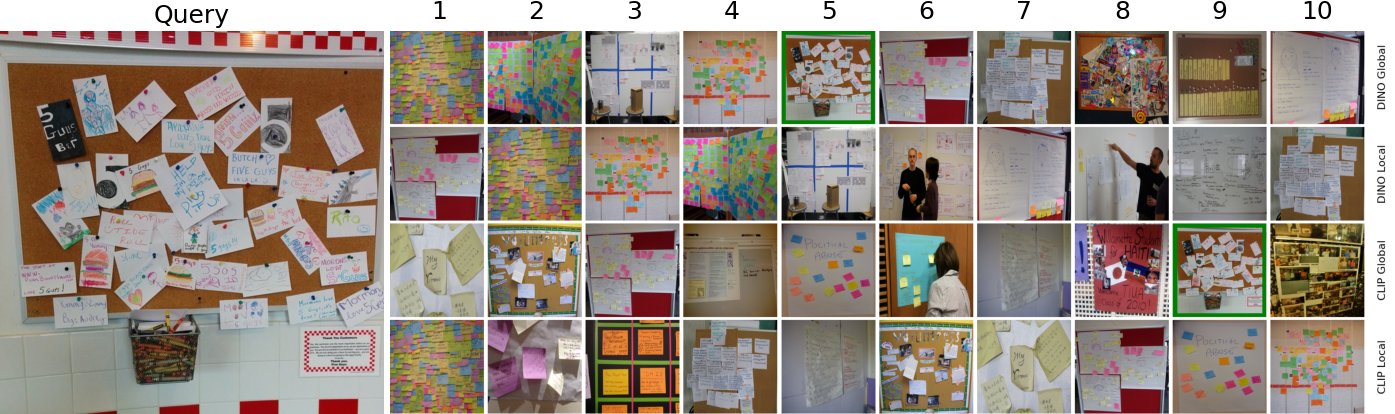

In [14]:
idx = 98369
feature_type = 'latents'
plot = plot_similar_images(idx, feature_type, k=10, show_title=True)
plot